##  Age-structured SIR model for South Africa with social distancing: plagiarism alert, lightly edited from India original

In example-4 we ran the age-structured SIR model for South Africa with the parameter $\beta$ fitted to case data. We can now examine the effect of interventions, **for an idealised best-case**. We assume that lockdown **instantaneously** and **completely** removes all social contacts from the spheres of workplace, schools, and others. The contact matrix, then, is time-dependent, whose form we take to be
$$
C_{ij}(t) = C_{ij} + u(t)(C^W_{ij} + C^S_{ij} + C^O_{ij}) 
$$
where $u(t)$ is a control function given by
$$
u(t) = \frac{1}{2}\left[\tanh\left(\frac{t-t_{\text on}}{t_w}\right)-\tanh\left(\frac{t-t_{\text off}}{t_w}\right)\right]
$$
This function has three parameters: the time at which the social distancing is implemented, $t_{\text on}$, the time at which it is lifted $t_{\text off}$ and the **lag** between implementation and compliance $t_w$. In the best-case scenario, we assume that this lag is less than day, or in other words, the lockdown acts  **instantaneously**. The function $u(t)$ is one in  window $t_{text \on} \leq t \leq t_{\text off}$ and zero outside. We can multiply this by a scale factor $0\leq \epsilon \leq 1$ as a measure of the efficacy of the social distancing. The value $\epsilon =1$ reflects complete compliance; the value $\epsilon=0$ reflects zero compliance. In the best-scenario, we assume  $\epsilon =1$ so there is no scale factor in the control function. 

We now numerically integrate as before, imposing controls of 21 days duration and lifting it afterwards. We also explore various other scenarios, with several periods of lockdown separated by periods of relaxation. The goal is to reduce the number of infectives. In the language of optimal control, our cost function is the number of infectives. We find that the 21 day lockdown will not reduce the number of infectives to a point where explicit contact tracing will be feasible. We take the number 10 to represent a point where social contact tracing may be feasible. This is dependent on region and the effectiveness with which such measures can be implemented. We find a longer lockdowns are needed to bring the number of infectives down to that level. 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
MM = np.array((0,0,.2,.2,.2,.2,.2,.2,.4,.4,1.3,1.3,3.6,3.6,8,8))  ## mortality per 100

In [3]:
## population and age classes
M=16  ## number of age classes

my_data = np.genfromtxt('data/age_structures/SouthAfrica-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [5]:
# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_2.xlsx', sheet_name='South Africa',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_2.xlsx', sheet_name='South Africa',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_2.xlsx', sheet_name='South Africa',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_2.xlsx', sheet_name='South Africa',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx', sheet_name='South Africa',index_col=None)
CA = np.array(my_data)
C=CH+CW+CS+CO

### One closure

In [40]:
beta  = 0.02         # contact rate parameter India: 0.01566
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.models.SIR(parameters, M, Ni)


# the contact matrix is time-dependent
def contactMatrix(t):
    if t<17:
        xx = C
    elif 15<=t<38:
        xx = CH
    else:
        xx = C
    return xx


# start simulation
# Nf is intervals within range, run over time 0..Tf
Tf=98.5;  Nf=2000; filename='this.mat'
model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

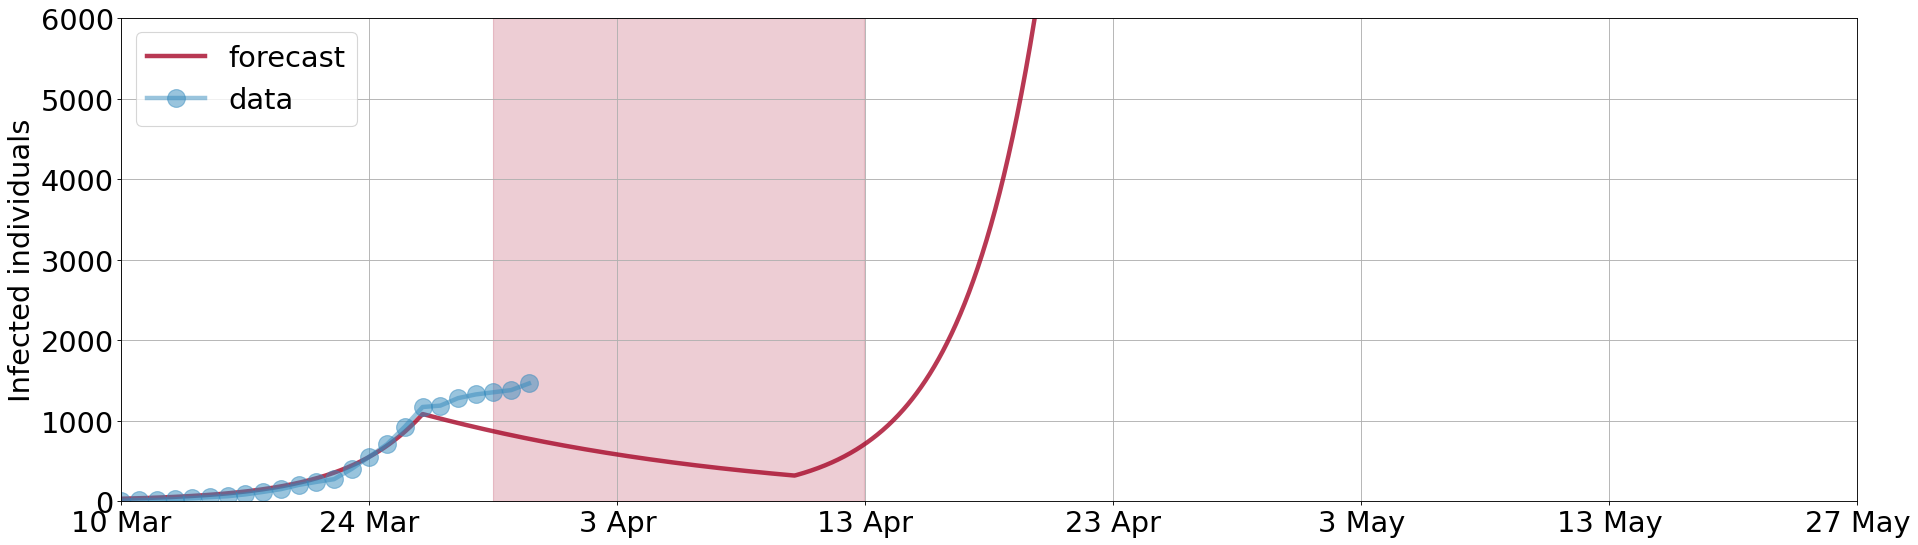

In [41]:
data=loadmat(filename)
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t'][0]
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('10 Mar', '24 Mar', '3 Apr', '13 Apr', '23 Apr', '3 May','13 May','27 May','10Jun'));
t1=int(Nf/14)
plt.fill_between(t[3*t1:6*t1], 0, 6000, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('data/covid-cases/southafrica.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 6000); plt.xlim(0, 98);
#plt.savefig('/Users/rsingh/Desktop/4a.png', format='png', dpi=200)

In [8]:
m1 = .01*MM*(data['X'][0,0:M]-data['X'][-1,0:M])
np.sum(m1)

153750.00281542947

### Two closures

In [47]:
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    elif 42<=t<47:
        xx = C
    elif 47<=t<68:
        xx = CH
    else:
        xx = C
    return xx

# start simulation
Tf=98;  Nf=2000; filename='this.mat'
model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

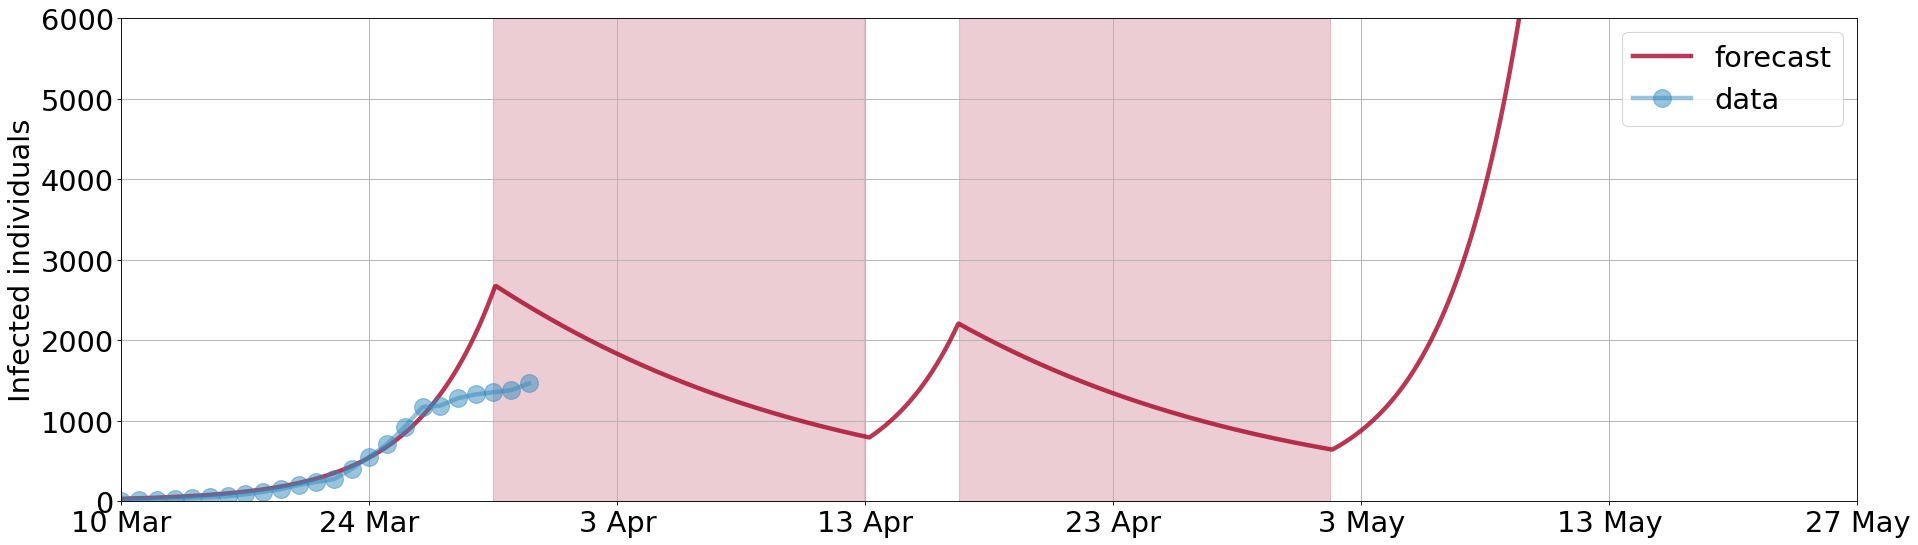

In [49]:
data=loadmat(filename)
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 

fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('10 Mar', '24 Mar', '3 Apr', '13 Apr', '23 Apr', '3 May','13 May','27 May','10Jun'));

t1=int(Nf/(14))
plt.fill_between(t[3*t1:6*t1], 0, 6000, color="#A60628", alpha=0.2)
plt.fill_between(t[6*t1+108:9*t1+108], 0, 6000, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('data/covid-cases/southafrica.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, 6000);
#plt.savefig('/Users/rsingh/Desktop/4b.png', format='png', dpi=200)

In [11]:
m1 = .01*MM*(data['X'][0,0:M]-data['X'][-1,0:M])
np.sum(m1)
SC[-1]-SC[0]

-119179.38087931275

In [12]:
## Three closures

In [54]:
def contactMatrix(t):
    if t < 17:
        xx = C
    elif 17<=t<38:
        xx = CH
    elif 38<=t<43:
        xx = C
    elif 43<=t<65:
        xx = CH
    elif 65<=t<70:
        xx = C
    else:
        xx = CH
    return xx


# start simulation
Tf=98;  Nf=2000; filename='this.mat'
model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

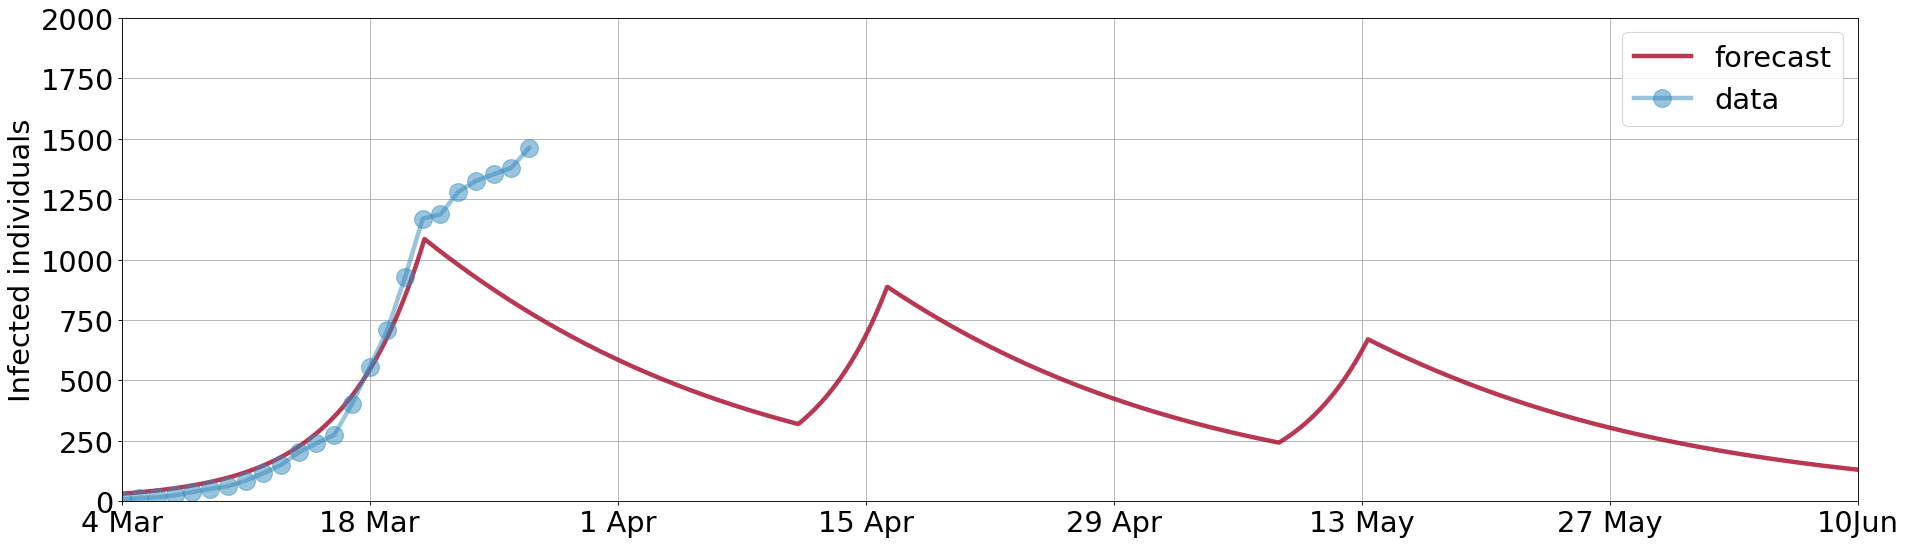

In [76]:
data=loadmat(filename)
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 

fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

t1=int(Nf/(14))
#plt.fill_between(t[2*t1:6*t1]-0.25, 0, 6000, color="#A60628", alpha=0.2)
#plt.fill_between(t[6*t1+108:10*t1+108], 0, 6000, color="#A60628", alpha=0.2)
#plt.fill_between(t[10*t1+213:14*t1+410], 0, 6000, color="#A60628", alpha=0.2)


my_data = np.genfromtxt('data/covid-cases/southafrica.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, 2000);
#plt.savefig('/Users/rsingh/Desktop/4b.png', format='png', dpi=200)

### One long closure

In [24]:
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<70:
        xx = CH
    else:
        xx = CH
    return xx


# start simulation
Tf=98;  Nf=2000; filename='this.mat'
model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

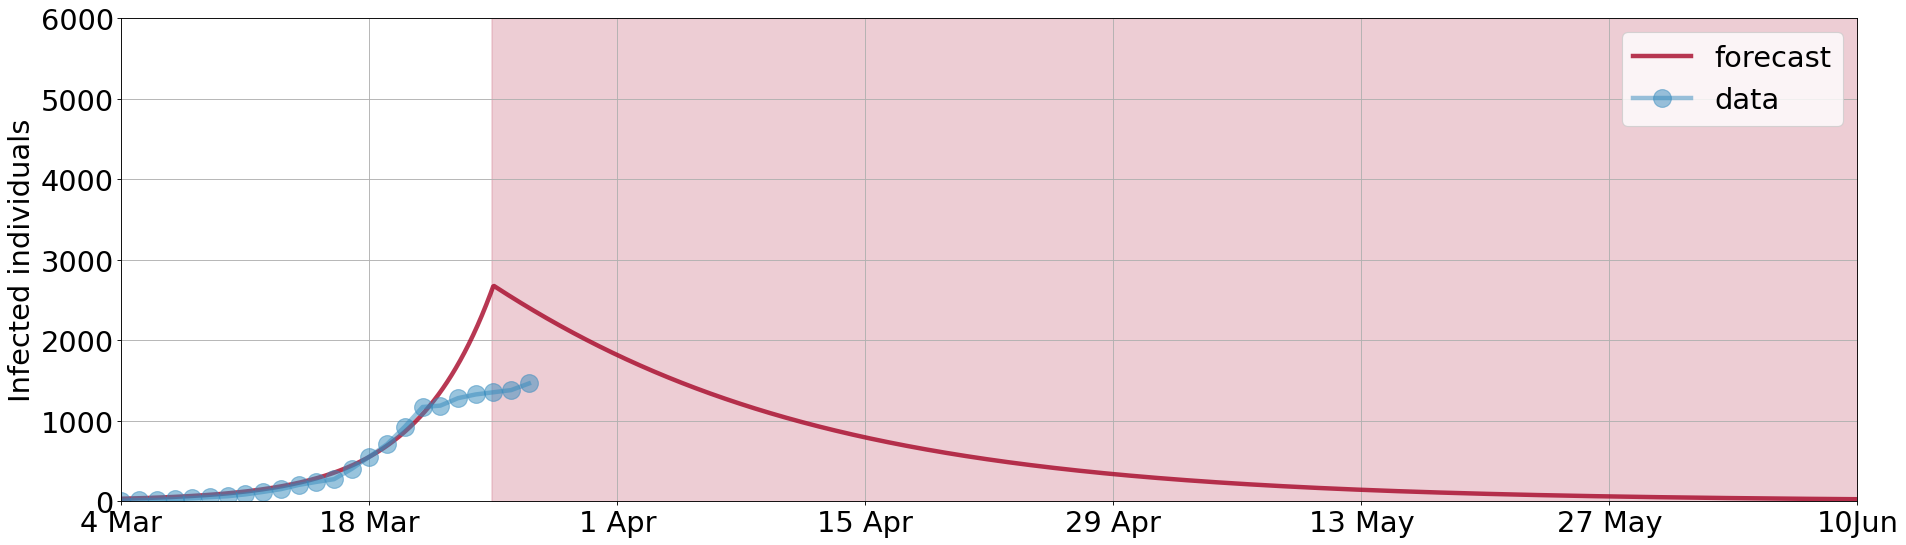

In [25]:
data=loadmat(filename)
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 

fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

t1=int(Nf/(14))
plt.fill_between(t[3*t1:16*t1], 0, 6000, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('data/covid-cases/southafrica.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, 6000);
#plt.savefig('/Users/rsingh/Desktop/4b.png', format='png', dpi=200)